# 1/4 Cluster Evolution using tensor contraction.
### 2D Ising Square Lattice Pos J with external Field

In [1]:
import torch
import numpy as np
import numba as nb
from scipy.linalg import sqrtm

In [2]:
import math
import time
from tqdm.auto import trange

In [3]:
import matplotlib.pyplot as plt

---------------------------------
### 1/4 Cluster

In [4]:
def parameters_init(dims_init, beta_init, j_init, h_init):
    global grid, dims, beta, j, h
    dims = (nb.int64(dims_init[0]), nb.int64(dims_init[1]))
    beta, j, h = nb.float64(beta_init), nb.float64(j_init), nb.int8(h_init)
    grid = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)

In [5]:
global grid, dims, beta, j, h

In [5]:
#dims_init = (4, 4)
#dims_init = (8, 8)
dims_init = (16, 16)
#dims_init = (32, 32)
#beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 1
beta_init, j_init, h_init = 1/5, 1, 1
parameters_init(dims_init, beta_init, j_init, h_init)

In [6]:
my_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
def node_tensor_create(my_device=my_device):
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    B = torch.tensor(sqrtm(np.array([[np.exp(beta*j),np.exp(-beta*j)], 
                                     [np.exp(-beta*j),np.exp(beta*j)]])), 
                     dtype=torch.float64, device=my_device)
    A_1 = torch.einsum("i, ij -> j", [I_1, B])
    A_2 = torch.einsum("ij, ab, jb -> ia", [B, B, I_2])
    A_3 = torch.einsum("ij, kl, mn, jln -> ikm", [B, B, B, I_3])
    A_4 = torch.einsum("ij, kl, mn, pq, jlnq -> ikmp", [B, B, B, B, I_4])
    spin_up = torch.tensor([1, 0], dtype=torch.float64, device=my_device)
    spin_down = torch.tensor([0, 1], dtype=torch.float64, device=my_device)
    spin_up = torch.einsum("i, ij -> j", [spin_up, B])
    spin_down = torch.einsum("i, ij -> j", [spin_down, B])
    return A_1, A_2, A_3, A_4, B, spin_up, spin_down

In [8]:
def copy_tensor_create(my_device=my_device):
    I_2_array = np.zeros((2, 2))
    I_3_array = np.zeros((2, 2, 2))
    I_4_array = np.zeros((2, 2, 2, 2))
    I_up_array = np.zeros((2, 2, 2, 2))
    I_down_array = np.zeros((2, 2, 2, 2))
    for i in range(2):
        if i == 0:
            I_2_array[i, i] = np.exp(beta * h)
            I_3_array[i, i, i] = np.exp(beta * h)
            I_4_array[i, i, i, i] = np.exp(beta * h)
        else:
            I_2_array[i, i] = np.exp(-beta * h)
            I_3_array[i, i, i] = np.exp(-beta * h)
            I_4_array[i, i, i, i] = np.exp(-beta * h)
    I_up_array[0][0][0][0] = np.exp(beta * h)
    I_down_array[1][1][1][1] = np.exp(-beta * h)
    I_1 = torch.tensor([np.exp(beta * h), np.exp(-beta * h)], dtype=torch.float64, device=my_device)
    I_2 = torch.tensor(I_2_array, dtype=torch.float64, device=my_device)
    I_3 = torch.tensor(I_3_array, dtype=torch.float64, device=my_device)
    I_4 = torch.tensor(I_4_array, dtype=torch.float64, device=my_device)
    I_up = torch.tensor(I_up_array, dtype=torch.float64, device=my_device)
    I_down = torch.tensor(I_down_array, dtype=torch.float64, device=my_device)
    return I_1, I_2, I_3, I_4, I_up, I_down

In [9]:
def row_tensor_mpo_create():
    len_mpo = dims[1] // 2
    row_tensor_mpo = []
    for _ in range(len_mpo):
        row_tensor_mpo.append(A_4[:])
    return row_tensor_mpo

In [10]:
global I_1, I_2, I_3, I_4, I_up, I_down

In [11]:
global A_1, A_2, A_3, A_4, B, spin_up, spin_down

In [12]:
global row_tensor_mpo

In [13]:
def tensors_init(my_device=my_device):
    global I_1, I_2, I_3, I_4, I_up, I_down
    global A_1, A_2, A_3, A_4, B, spin_up, spin_down
    global row_tensor_mpo
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    A_1, A_2, A_3, A_4, B, spin_up, spin_down = node_tensor_create(my_device)
    row_tensor_mpo = row_tensor_mpo_create()

In [14]:
tensors_init()

In [15]:
def row_tensor_create(grid, id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy, my_device=my_device):
    #num_rows = dims[0] // 2
    num_rows = id_right_bdy - id_left_bdy + 1
    left_bdy_list, right_bdy_list = [], []
    up_bdy_list, down_bdy_list = [], []
    for i in range(id_up_bdy, id_down_bdy+1):
        left_bdy_list.append(spin_up if grid[i][(id_left_bdy-1)%dims[1]] == 1 else spin_down)
        right_bdy_list.append(spin_up if grid[i][(id_right_bdy+1)%dims[1]] == 1 else spin_down)
    for jj in range(id_left_bdy, id_right_bdy+1):
        up_bdy_list.append(spin_up if grid[(id_up_bdy-1)%dims[0]][jj] == 1 else spin_down)
        down_bdy_list.append(spin_up if grid[(id_down_bdy+1)%dims[0]][jj] == 1 else spin_down)
    ### contracting boundary vector with mpo to get the col mps
    row_up_mps, row_down_mps = [], []
    start_up_tensor = torch.einsum("ijkl, l, mi -> mjk", [A_4, up_bdy_list[0], torch.unsqueeze(left_bdy_list[0], 0)])
    start_down_tensor = torch.einsum("ijkl, j, mi -> mkl", [A_4, down_bdy_list[0], torch.unsqueeze(left_bdy_list[-1], 0)])
    row_up_mps.append(start_up_tensor)
    row_down_mps.append(start_down_tensor)
    for i in range(num_rows-2):
        tensor_up_mps = torch.einsum("ijkl, l -> ijk", [A_4, up_bdy_list[i+1]])
        tensor_down_mps = torch.einsum("ijkl, j -> ikl", [A_4, down_bdy_list[i+1]])
        row_up_mps.append(tensor_up_mps)
        row_down_mps.append(tensor_down_mps)                           
    end_up_tensor = torch.einsum("ijkl, l, km -> ijm", [A_4, up_bdy_list[-1], torch.unsqueeze(right_bdy_list[0], 1)])
    end_down_tensor = torch.einsum("ijkl, j, km -> iml", [A_4, down_bdy_list[-1], torch.unsqueeze(right_bdy_list[-1], 1)])
    row_up_mps.append(end_up_tensor)
    row_down_mps.append(end_down_tensor)
    return row_up_mps, row_down_mps

In [16]:
def row_down_mps_create(grid, id_bdy, id_row):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy 
    #num_rows = dims[1] // 2
    num_rows = id_right_bdy - id_left_bdy + 1
    down_bdy_list = []
    for jj in range(id_left_bdy, id_right_bdy+1):
        down_bdy_list.append(spin_up if grid[(id_row+1)%dims[0]][jj] == 1 else spin_down)
    left_bdy_vector = spin_up if grid[id_row][(id_left_bdy-1)%dims[1]] == 1 else spin_down
    right_bdy_vector = spin_up if grid[id_row][(id_right_bdy+1)%dims[1]] == 1 else spin_down
    ### contracting boundary vector with mpo to get the row mps   
    row_down_mps = []
    start_down_tensor = torch.einsum("ijkl, j, mi -> mkl", [A_4, down_bdy_list[0], torch.unsqueeze(left_bdy_vector, 0)])
    row_down_mps.append(start_down_tensor)
    for i in range(num_rows-2):
        tensor_down_mps = torch.einsum("ijkl, j -> ikl", [A_4, down_bdy_list[i+1]])
        row_down_mps.append(tensor_down_mps)                           
    end_down_tensor = torch.einsum("ijkl, j, km -> iml", [A_4, down_bdy_list[-1], torch.unsqueeze(right_bdy_vector, 1)])
    row_down_mps.append(end_down_tensor)
    return row_down_mps

In [17]:
def eat(mps, mpo):
    return [torch.einsum("ijk, abcj-> iabkc", mps[i], mpo[i]).contiguous().view(mps[i].shape[0] * mpo[i].shape[0], 2, -1) 
            for i in range(len(mps))]     

In [18]:
def compress(mps, chi):
    residual = 0
    for i in range(len(mps)-1): # From left to right, sweep once doing qr decompositions
        Q, R = torch.qr(mps[i].contiguous().view(mps[i].shape[0]*2, -1))
        mps[i] = Q.contiguous().view(mps[i].shape[0], 2, -1)
        mps[i+1] = torch.einsum("ij,jab->iab", [R, mps[i+1]])
    for i in range(len(mps) - 1, 0, -1): # From right to left, sweep onece using svd on the tensor merged from two consecutive tensors.
        [U,s,V]=torch.svd(torch.einsum("ijk, kab->ijab", mps[i-1], mps[i]).view(mps[i-1].shape[0] * 2, mps[i].shape[2]*2))
        mps[i] = V[:, :chi].t().contiguous().view(-1, 2, mps[i].shape[2])
        mps[i-1] = (U[:, :chi]@torch.diag(s[:chi])).contiguous().view(mps[i-1].shape[0],2,-1)
        tnorm=mps[i-1].norm()
        mps[i-1] /= tnorm
        residual += math.log(tnorm)
    return residual, mps

In [19]:
def contract_up_to_down(grid, id_bdy, bond_dims=20):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    row_up_mps, row_down_mps = row_tensor_create(grid, id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy)
    stack_mps = []
    num_rows = id_down_bdy - id_up_bdy + 1
    stack_mps.append(row_up_mps)
    mps_orig = row_up_mps
    row_tensor_mpo_bdy = row_tensor_mpo[:]
    for i in range(num_rows-2):
        spin_left_vector = spin_up if grid[id_up_bdy+i+1][(id_left_bdy-1)%dims[1]] == 1 else spin_down
        spin_right_vector = spin_up if grid[id_up_bdy+i+1][(id_right_bdy+1)%dims[1]] == 1 else spin_down
        row_tensor_mpo_bdy[0] = torch.einsum("ijkl, mi -> mjkl", [A_4, torch.unsqueeze(spin_left_vector, 0)])
        row_tensor_mpo_bdy[-1] = torch.einsum("ijkl, km -> ijml", [A_4, torch.unsqueeze(spin_right_vector, 1)])
        mps_orig = eat(mps_orig, row_tensor_mpo_bdy)
        #_, mps_orig = compress(mps_orig, bond_dims)
        stack_mps.append(mps_orig)
    return stack_mps, row_down_mps

In [20]:
def row_sampling(grid, id_row, id_bdy, mps_base, row_down_mps, my_device=my_device):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    #mps_base = stack_mps.pop()
    stack_contract = []
    tensor_start = torch.einsum("ijk, lmj -> ilkm", [mps_base[-1], row_down_mps[-1]])
    tensor_start = tensor_start.squeeze()
    ### tensor_start shape il
    stack_contract.append(tensor_start)
    for i in range(len(mps_base)-2, 0, -1):
        tensor_i = torch.einsum("ijk, lmj -> ilkm", [mps_base[i], row_down_mps[i]])
        tensor_start = torch.einsum("ijkl, kl -> ij", [tensor_i, tensor_start])
        stack_contract.append(tensor_start)
    ### Samping the head of the row
    id_tensor = 0
    left_bdy_vector = spin_up if grid[id_row][(id_left_bdy-1)%dims[1]] == 1 else spin_down
    down_bdy_vector = spin_up if grid[(id_row+1)%dims[0]][id_left_bdy] == 1 else spin_down
    tensor_right = stack_contract.pop()
    tensor_right = torch.einsum("ij, mj -> im ", [tensor_right, B])
    tensor_down = torch.einsum("ij, j -> i", [B, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B, left_bdy_vector])
    tensor_up = mps_base[id_tensor]
    tensor_up = torch.einsum("ijk, jl -> ilk", [tensor_up, B])
    tensor_up = tensor_up.squeeze()
    ### tensor_up shape lk
    z_four_edge = torch.einsum("ij, jl, k, m -> ilkm", [tensor_up, tensor_right, tensor_down, tensor_left])
    #z_up = z_four_edge[0][0][0][0]
    #z_down = z_four_edge[1][1][1][1]
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    prob_up = z_up / (z_up + z_down)
    #print(z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up:
        grid[id_row][id_left_bdy] = 1
        spin_vector = torch.tensor([1, 0], dtype=torch.float64, device=my_device)
    else:
        grid[id_row][id_left_bdy] = -1
        spin_vector = torch.tensor([0, 1], dtype=torch.float64, device=my_device)
    #print(tensor_up)
    #print(spin_vector)
    tensor_up = torch.einsum("ij, i -> j", [tensor_up, spin_vector])
    id_tensor += 1
    ### Sampling the body of the row
    for i in range(id_left_bdy+1, id_right_bdy):
        left_bdy_vector = spin_up if grid[id_row][(i-1)%dims[0]] == 1 else spin_down
        down_bdy_vector = spin_up if grid[(id_row+1)%dims[1]][i] == 1 else spin_down 
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("ij, mj -> im", [tensor_right, B])
        tensor_left = torch.einsum("ij, j -> i", [B, left_bdy_vector])
        tensor_up = torch.einsum("i, ijk, jl -> lk", [tensor_up, mps_base[id_tensor], B])
        tensor_down = torch.einsum("ij, j -> i", [B, down_bdy_vector])
        z_four_edge = torch.einsum("ij, jk, m, n -> ikmn", [tensor_up, tensor_right, tensor_down, tensor_left])
        #z_up = z_four_edge[0][0][0][0]
        #z_down = z_four_edge[1][1][1][1]
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        prob_up = z_up / (z_up + z_down)
        #print(z_up + z_down)
        prob_rand = np.random.random()
        if prob_rand < prob_up:
            grid[id_row][i] = 1
            spin_vector = torch.tensor([1, 0], dtype=torch.float64, device=my_device)
        else:
            grid[id_row][i] = -1
            spin_vector = torch.tensor([0, 1], dtype=torch.float64, device=my_device)
        tensor_up = torch.einsum("ij, i -> j", [tensor_up, spin_vector])
        id_tensor += 1
    ### Sampling the end of the row
    left_bdy_vector = spin_up if grid[id_row][(id_right_bdy-1)%dims[1]] == 1 else spin_down
    down_bdy_vector = spin_up if grid[(id_row+1)%dims[0]][id_right_bdy] == 1 else spin_down
    right_bdy_vector = spin_up if grid[id_row][(id_right_bdy+1)%dims[1]] == 1 else spin_down
    tensor_right = torch.einsum("ij, j -> i", [B, right_bdy_vector])
    tensor_down = torch.einsum("ij, j -> i", [B, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B, left_bdy_vector])
    tensor_up = torch.einsum("j, jik, il -> lk", [tensor_up, mps_base[id_tensor], B])
    tensor_up = tensor_up.squeeze()
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    #z_up = z_four_edge[0][0][0][0]
    #z_down = z_four_edge[1][1][1][1]
    #print(z_up + z_down)
    prob_up = z_up / (z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up:
        grid[id_row][id_right_bdy] = 1
        spin_vector = torch.tensor([1, 0], dtype=torch.float64, device=my_device)
    else:
        grid[id_row][id_right_bdy] = -1
        spin_vector = torch.tensor([0, 1], dtype=torch.float64, device=my_device)
    return grid

In [21]:
def mps_contract(mps_up, mps_down):
    tensor_start = torch.einsum("ijk, lmj -> ilkm", [mps_up[0], mps_down[0]])
    tensor_start = torch.squeeze(tensor_start)
    for i in range(1, len(mps_up)-1):
        tensor_i = torch.einsum("ijk, lmj -> ilkm", [mps_up[i], mps_down[i]])
        tensor_start = torch.einsum("ij, ijkl -> kl", [tensor_start, tensor_i])
    tensor_end = torch.einsum("iml, jkm -> ijlk", [mps_up[-1], mps_down[-1]])
    tensor_end = torch.squeeze(tensor_end)
    z = torch.einsum("ij, ij -> ", [tensor_start, tensor_end])
    return z

In [22]:
def base_row_sampling(grid, id_bdy):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    id_row = id_up_bdy
    base_row_mps = row_down_mps_create(grid, id_bdy, id_row)
    stack_contract, up_bdy_vector_list = [], []
    up_bdy_vector = spin_up if grid[(id_up_bdy-1)%dims[0]][id_right_bdy] == 1 else spin_down
    tensor_start = torch.einsum("ijk, k -> ij", [base_row_mps[-1], up_bdy_vector])
    tensor_start = tensor_start.squeeze()
    ### tensor_start shape i
    id_tensor = -2
    stack_contract.append(tensor_start)
    up_bdy_vector_list.append(up_bdy_vector)
    for i in range(id_right_bdy-1, id_left_bdy, -1):
        up_bdy_vector = spin_up if grid[(id_up_bdy-1)%dims[0]][i] == 1 else spin_down
        tensor_i = torch.einsum("ijk, k -> ij", [base_row_mps[id_tensor], up_bdy_vector])
        tensor_start = torch.einsum("ik, k -> i", [tensor_i, tensor_start])
        stack_contract.append(tensor_start)
        up_bdy_vector_list.append(up_bdy_vector)
        id_tensor -= 1
    ### Samping the head of the row
    id_tensor = 0
    left_bdy_vector = spin_up if grid[id_up_bdy][(id_left_bdy-1)%dims[1]] == 1 else spin_down
    down_bdy_vector = spin_up if grid[(id_up_bdy+1)%dims[0]][id_left_bdy] == 1 else spin_down
    up_bdy_vector = spin_up if grid[(id_up_bdy-1)%dims[0]][id_left_bdy] == 1 else spin_down
    #up_bdy_vector = up_bdy_vector_list.pop()
    tensor_right = stack_contract.pop()
    tensor_right = torch.einsum("i, mi -> m", [tensor_right, B])
    tensor_down = torch.einsum("ij, j -> i", [B, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B, left_bdy_vector])
    tensor_up = torch.einsum("ij, j -> i", [B, up_bdy_vector])
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    #z_up = z_four_edge[0][0][0][0]
    #z_down = z_four_edge[1][1][1][1]
    #print(z_up + z_down)
    prob_up = z_up / (z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up:
        grid[id_up_bdy][id_left_bdy] = 1
        #spin_vector = torch.tensor([1, 0], dtype=torch.float64, device=my_device)
        spin_vector = spin_up
    else:
        grid[id_up_bdy][id_left_bdy] = -1
        spin_vector = spin_down
        #spin_vector = torch.tensor([0, 1], dtype=torch.float64, device=my_device)
    #print(tensor_up)
    #print(spin_vector)
    ### Sampling the body of the row
    for i in range(id_left_bdy+1, id_right_bdy):
        up_bdy_vector = up_bdy_vector_list.pop()
        left_bdy_vector = spin_vector
        down_bdy_vector = spin_up if grid[(id_up_bdy+1)%dims[0]][i] == 1 else spin_down
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("i, mi -> m", [tensor_right, B])
        tensor_left = torch.einsum("ij, i -> j", [B, left_bdy_vector])
        tensor_up = torch.einsum("i, ij -> j", [up_bdy_vector, B])
        tensor_down = torch.einsum("ij, i -> j", [B, down_bdy_vector])
        z_four_edge = torch.einsum("i, j, m, n -> ijmn", [tensor_up, tensor_right, tensor_down, tensor_left])
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        #z_up = z_four_edge[0][0][0][0]
        #z_down = z_four_edge[1][1][1][1]
        prob_up = z_up / (z_up + z_down)
        #print(z_up + z_down)
        prob_rand = np.random.random()
        if prob_rand < prob_up:
            grid[id_up_bdy][i] = 1
            spin_vector = spin_up
        else:
            grid[id_up_bdy][i] = -1
            spin_vector = spin_down
    ### Sampling the end of the row
    left_bdy_vector = spin_vector
    up_bdy_vector = up_bdy_vector_list.pop()
    down_bdy_vector = spin_up if grid[(id_up_bdy+1)%dims[0]][id_right_bdy] == 1 else spin_down
    right_bdy_vector = spin_up if grid[id_up_bdy][(id_right_bdy+1)%dims[1]] == 1 else spin_down
    tensor_right = torch.einsum("j, ij -> i", [right_bdy_vector, B])
    tensor_down = torch.einsum("ij, j -> i", [B, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B, left_bdy_vector])
    tensor_up = torch.einsum("j, ij -> i", [up_bdy_vector, B])
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    #z_up = z_four_edge[0][0][0][0]
    #z_down = z_four_edge[1][1][1][1]
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    prob_up = z_up / (z_up + z_down)
    #print(z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up:
        grid[id_up_bdy][id_right_bdy] = 1
    else:
        grid[id_up_bdy][id_right_bdy] = -1
    return grid

In [23]:
types_neibor_get_triangle_func = nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 4)(nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibor_get_triangle_func)
def neibor_get_square(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    l_neibor = (height_index, (width_index - 1) % width)
    r_neibor = (height_index, (width_index + 1) % width)
    u_neibor = ((height_index - 1) % height, width_index)
    d_neibor = ((height_index + 1) % height, width_index)
    return (l_neibor, r_neibor, u_neibor, d_neibor)

In [24]:
@nb.njit
def dec_to_bin(num_dec, width):
    num_bin_array = np.zeros(width)
    for i in range(width-1, -1, -1):
        num_bin_array[i] = num_dec % 2
        num_dec = num_dec // 2
        if num_dec == 0:
            break
    return num_bin_array

In [25]:
@nb.njit
def z_compute(grid, id_bdy):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    num_rows = id_down_bdy - id_up_bdy + 1
    num_cols = id_right_bdy - id_left_bdy + 1
    z = 0
    num_sites = num_rows * num_cols
    num_grids = 2 ** num_sites
    for i in range(num_grids):
        subgrid = dec_to_bin(i, num_sites)
        subgrid_reshaped = np.zeros((num_rows, num_cols), dtype=np.int8)
        for i in range(num_rows):
            subgrid_reshaped[i] = subgrid[i*num_cols: (i+1)*num_cols]
        subgrid = (-1) ** subgrid_reshaped
        grid[:num_rows, :num_cols] = subgrid
        energy_total = 0
        for ii in range(num_rows):
            for jj in range(num_cols):
                id_neibors = neibor_get_square((nb.int8(ii), nb.int8(jj)))
                left_id, right_id, up_id, down_id = id_neibors
                if ii == id_up_bdy:
                    if jj == id_left_bdy:
                        energy_l = -j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -1 / 2 * j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -1.0 / 2 * j * grid[down_id[0]][down_id[1]] * grid[ii][jj]
                    elif jj == id_right_bdy:
                        energy_l = -1.0 / 2 * j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -1.0 / 2 * j * grid[down_id[0]][down_id[1]] * grid[ii][jj]
                    else:
                        energy_l = -1.0 / 2 * j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -1.0 / 2 * j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -1.0 / 2 * j * grid[down_id[0]][down_id[1]] * grid[ii][jj]                    
                elif ii == id_down_bdy:
                    if jj == id_left_bdy:
                        energy_l = -j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -1.0 / 2 * j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -1.0 / 2 * j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -j * grid[down_id[0]][down_id[1]] * grid[ii][jj]
                    elif jj == id_right_bdy:
                        energy_l = -1.0 / 2 * j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -1.0 / 2 * j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -j * grid[down_id[0]][down_id[1]] * grid[ii][jj]
                    else:
                        energy_l = -1.0 / 2 * j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -1.0 / 2 * j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -1.0 / 2 * j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -j * grid[down_id[0]][down_id[1]] * grid[ii][jj]
                else:
                    if jj == id_left_bdy:
                        energy_l = -j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -1.0 / 2 * j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -1.0 / 2 * j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -1.0 / 2 * j * grid[down_id[0]][down_id[1]] * grid[ii][jj]
                    elif jj == id_right_bdy:
                        energy_l = -1.0 / 2 * j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -1.0 / 2 * j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -1.0 / 2 * j * grid[down_id[0]][down_id[1]] * grid[ii][jj]
                    else:
                        energy_l = -1.0 / 2 * j * grid[left_id[0]][left_id[1]] * grid[ii][jj]
                        energy_r = -1.0 / 2 * j * grid[right_id[0]][right_id[1]] * grid[ii][jj]
                        energy_u = -1.0 / 2 * j * grid[up_id[0]][up_id[1]] * grid[ii][jj]
                        energy_d = -1.0 / 2 * j * grid[down_id[0]][down_id[1]] * grid[ii][jj]     
                energy_ij = energy_l + energy_r + energy_u + energy_d
                energy_total += energy_ij 
        z_part = np.exp(-beta * energy_total)
        z += z_part 
    return z

In [26]:
def one_forth_sampling(grid, id_bdy, bond_dim=20):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    stack_mps, row_down_mps = contract_up_to_down(grid, id_bdy, bond_dim)
    mps_base = stack_mps.pop()
    grid = row_sampling(grid, id_down_bdy, id_bdy, mps_base, row_down_mps)
    for i in range(id_down_bdy-1, id_up_bdy, -1):
        mps_base = stack_mps.pop()
        row_down_mps_i = row_down_mps_create(grid, id_bdy, i)
        grid = row_sampling(grid, i, id_bdy, mps_base, row_down_mps_i)
    grid = base_row_sampling(grid, id_bdy)
    return grid

In [27]:
def block_sampling_one_step(grid):
    num_rows, num_cols = dims[0], dims[1]
    row_bdy_1, row_bdy_2, row_bdy_3 = 0, num_rows // 2 - 1, num_rows - 1
    col_bdy_1, col_bdy_2, col_bdy_3 = 0, num_cols // 2 - 1, num_cols - 1
    # ul, ur
    # dl, dr
    id_bdy_dl = (col_bdy_1, col_bdy_2, row_bdy_1, row_bdy_2)
    id_bdy_dr = (col_bdy_2+1, col_bdy_3, row_bdy_1, row_bdy_2)
    id_bdy_ul = (col_bdy_1, col_bdy_2, row_bdy_2+1, row_bdy_3)
    id_bdy_ur = (col_bdy_2+1, col_bdy_3, row_bdy_2+1, row_bdy_3)
    # sampling all the four pieces of the block
    grid = one_forth_sampling(grid, id_bdy_dl)
    grid = one_forth_sampling(grid, id_bdy_dr)
    grid = one_forth_sampling(grid, id_bdy_ul)
    grid = one_forth_sampling(grid, id_bdy_ur)
    return grid

In [28]:
def block_sampling_one_step_arbitrary(grid, bond_dim):
    num_rows, num_cols = dims[0], dims[1]
    row_bdy_1, row_bdy_2 = (0, num_rows // 4 - 1), (num_rows // 4, num_rows // 2 - 1)
    row_bdy_3, row_bdy_4 = (num_rows // 2, num_rows // 4 * 3 - 1), (num_rows // 4 * 3, num_rows - 1)
    col_bdy_1, col_bdy_2 = (0, num_cols // 4 - 1), (num_cols // 4, num_cols // 2 - 1)
    col_bdy_3, col_bdy_4 = (num_cols // 2, num_cols // 4 * 3 - 1), (num_cols // 4 * 3, num_cols - 1)  
    row_list = [row_bdy_1, row_bdy_2, row_bdy_3, row_bdy_4]
    col_list = [col_bdy_1, col_bdy_2, col_bdy_3, col_bdy_4]
    for row in row_list:
        for col in col_list:
            id_bdy_i = row + col
            grid = one_forth_sampling(grid, id_bdy_i, bond_dim)
    return grid

In [29]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibor_get_square((nb.int8(ii), nb.int8(jj)))
            for ij in id_neibors:
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [30]:
@nb.njit(nb.float32(nb.int8[:, :]))
def magnet_grids(grids):
    m_mean = np.mean(grids)
    return m_mean

In [31]:
def grid_transform(grid):
    id_rand = np.random.randint(0, dims[0]*dims[1])
    id_row, id_col = id_rand // dims[0], id_rand % dims[0]
    grid_new = np.zeros((dims[0], dims[1]), dtype=np.int8)
    grid_new[:dims[0]-id_row, :dims[1]-id_col] = grid[id_row:, id_col:]
    grid_new[:dims[0]-id_row, dims[1]-id_col:] = grid[id_row:, :id_col]
    grid_new[dims[0]-id_row:, :dims[1]-id_col] = grid[:id_row, id_col:]
    grid_new[dims[0]-id_row:, dims[1]-id_col:] = grid[:id_row, :id_col]
    return grid_new

In [32]:
def one_forth_evv(grid, num_steps, bond_dim=20):
    magnet_list = []
    energy_list = []
    for i in trange(num_steps):
        #grid = block_sampling_one_step_arbitrary(grid, bond_dim)
        grid = block_sampling_one_step(grid)
        #grid = grid_transform(grid)
        energy_per_spin = energy_compute_grids(grid)
        magnet_per_spin = magnet_grids(grid)
        energy_list.append(energy_per_spin)
        magnet_list.append(magnet_per_spin)
    return grid, energy_list, magnet_list

In [33]:
def spin_viz(figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grid*np.pi/2)
    v = np.sin(grid*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

-------------------

s1 s2 
s3 s4

In [55]:
z_total = 0
for s1 in [1, -1]:
    for s2 in [1, -1]:
        for s3 in [1, -1]:
            for s4 in [1, -1]:
                e_1 = -j * (s1 * s2 + s1 * s3) - h * s1
                e_2 = -j * (s1 * s2 + s2 * s4) - h * s2
                e_3 = -j * (s1 * s3 + s4 * s3) - h * s3
                e_4 = -j * (s4 * s3 + s4 * s2) - h * s4
                z = np.exp(-beta * (e_1 + e_2 + e_3 + e_4))
                z_total += z

In [56]:
z_total

219.19595949289322

In [57]:
tensor_up = torch.einsum("ijkl, kmip -> lpjm", [A_4, A_4])
tensor_down = torch.einsum("ijkl, kmip -> lpjm", [A_4, A_4])

In [58]:
z_contract = torch.einsum("ijkl, klij -> ", [tensor_up, tensor_down])

In [59]:
z_contract

tensor(219.1960, dtype=torch.float64)

-----------------
### beta = 1

In [36]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
grid, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 223.32575607299805.


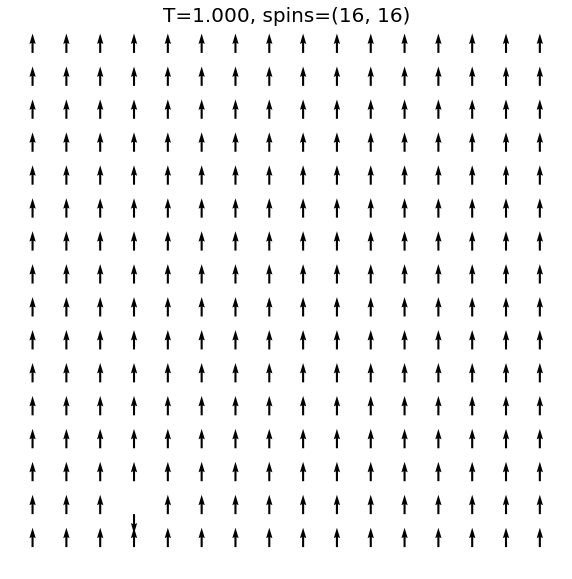

In [63]:
spin_viz()

In [64]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.9991953125.


---------------------------
### beta = 1 / 1.4

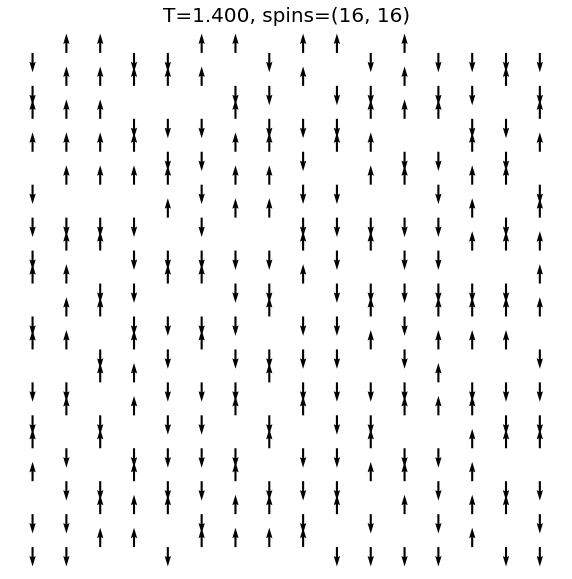

In [35]:
spin_viz()

In [36]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
grid, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 250.08552289009094.


In [38]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.9984375.


-------------
### beta = 1 / 1.8

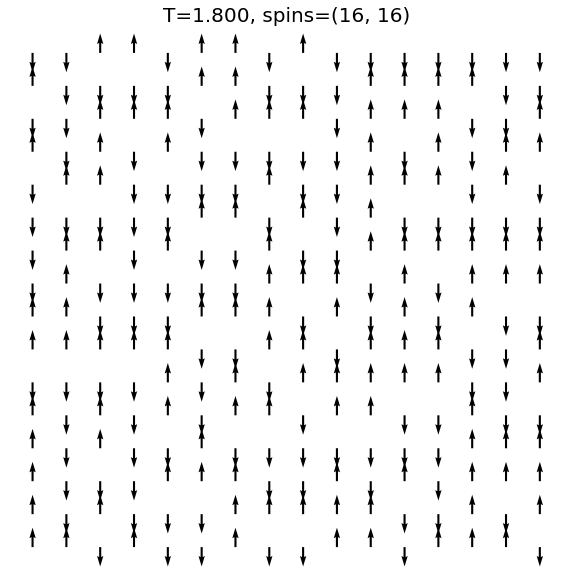

In [35]:
spin_viz()

In [36]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
grid, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 241.92491269111633.


In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.9907578125.


------
### beta = 1 / 2.2

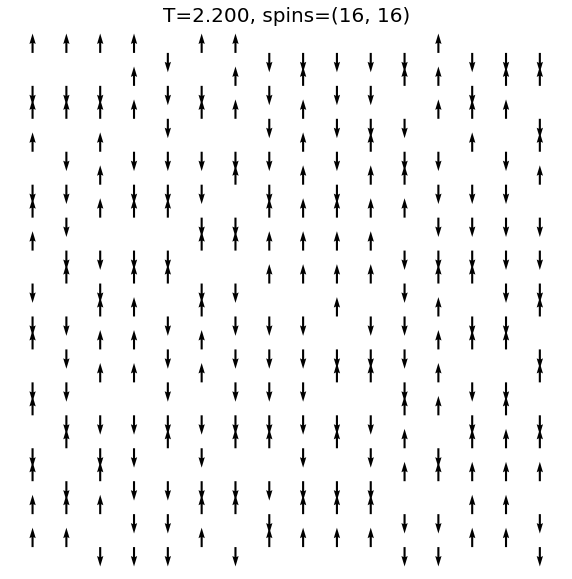

In [38]:
spin_viz()

In [39]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
grid, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 243.6990737915039.


In [41]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.9722265625.


-------
### beta = 1 / 2.6

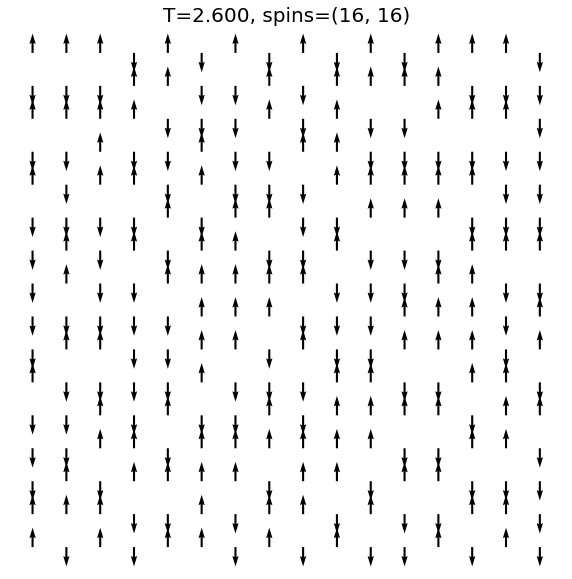

In [35]:
spin_viz()

In [36]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
grid, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E4 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E4 steps is: 240.93132638931274.


In [38]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.93709375.


-----
### beta = 1 / 3

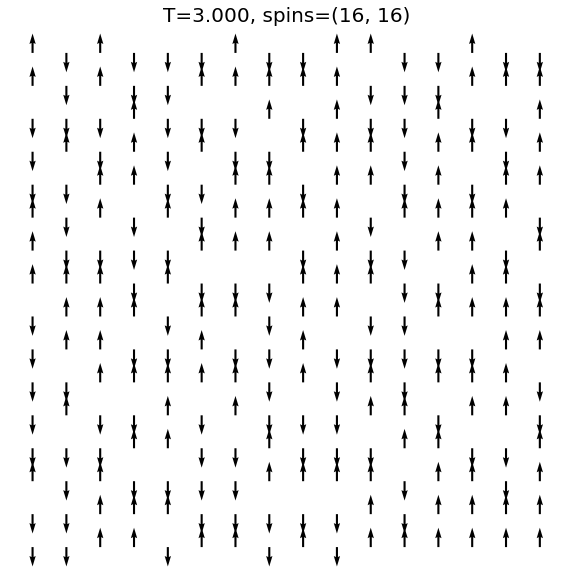

In [35]:
spin_viz()

In [36]:
### Burning../data_2d_ising/age
time_start = time.time()
num_steps = 1000
grids, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 245.5507481098175.


In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.8864609375.


--------
### Beta = 1 / 3.4

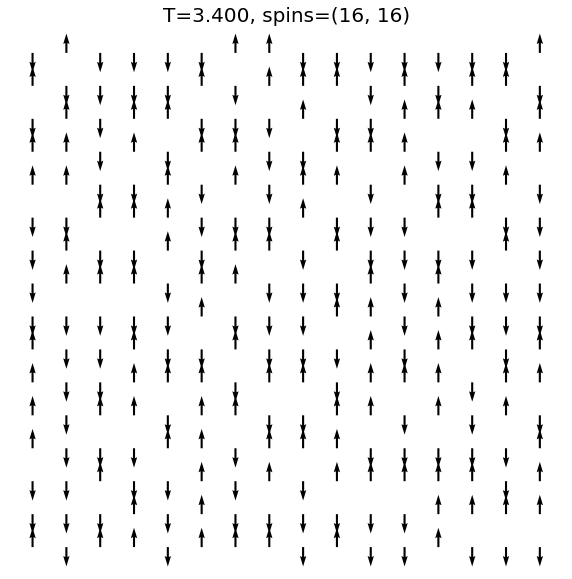

In [35]:
spin_viz()

In [36]:
### Burning../data_2d_ising/age
time_start = time.time()
num_steps = 1000
grids, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 244.04400753974915.


In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.81128125.


--------
### Beta = 1 / 3.8

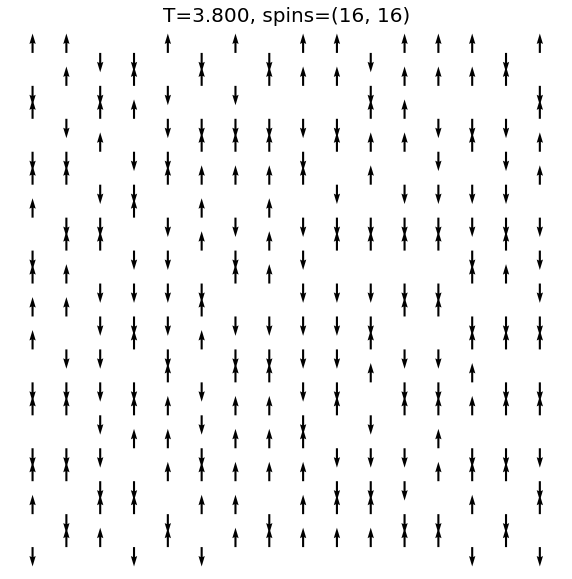

In [35]:
spin_viz()

In [36]:
### Burning../data_2d_ising/age
time_start = time.time()
num_steps = 1000
grids, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 239.55399227142334.


In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.721171875.


--------
### Beta = 1 / 4.2

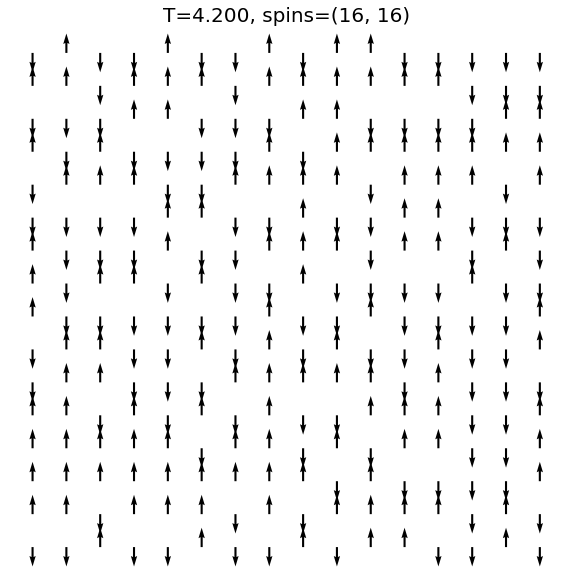

In [35]:
spin_viz()

In [36]:
### Burning../data_2d_ising/age
time_start = time.time()
num_steps = 1000
grids, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 335.62999200820923.


In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.639390625.


------------
### Beta = 1 / 4.6

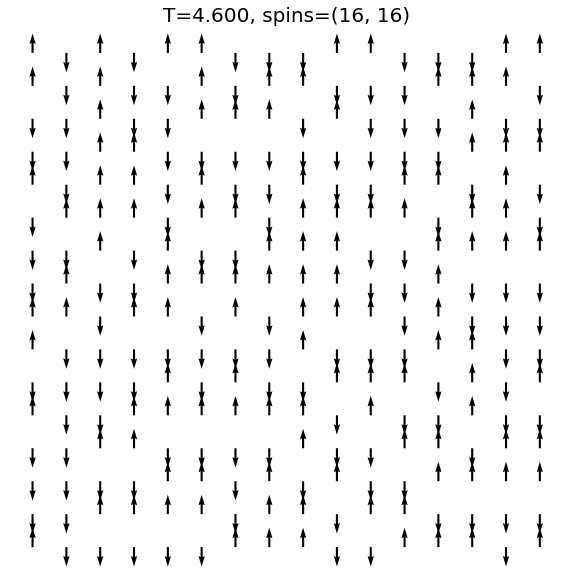

In [35]:
spin_viz()

In [36]:
### Burning../data_2d_ising/age
time_start = time.time()
num_steps = 1000
grids, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 344.5303809642792.


In [38]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.5550703125.


-----------------------
### Beta  = 1 / 5

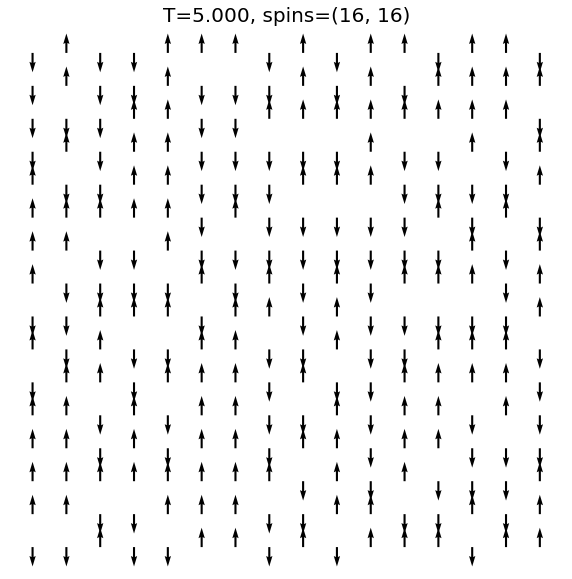

In [34]:
spin_viz()

In [35]:
### Burning../data_2d_ising/age
time_start = time.time()
num_steps = 1000
grids, energy_history, m_history = one_forth_evv(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 341.4896433353424.


In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.4824140625.


------
### Metropolis 

In [39]:
import pickle

In [40]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.2_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_1 = pickle.load(file)

In [41]:
m_abs_1_mean = np.mean(np.abs(m_abs_array_1))

In [42]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.21739_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_2 = pickle.load(file)

In [43]:
m_abs_2_mean = np.mean(np.abs(m_abs_array_2))

In [44]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.23809_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_3 = pickle.load(file)

In [45]:
m_abs_3_mean = np.mean(m_abs_array_3)

In [46]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.26316_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_4 = pickle.load(file)

In [47]:
m_abs_4_mean = np.mean(np.abs(m_abs_array_4))

In [48]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.29412_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_5 = pickle.load(file)

In [49]:
m_abs_5_mean = np.mean(np.abs(m_abs_array_5))

In [50]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.33333_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_6 = pickle.load(file)

In [51]:
m_abs_6_mean = np.mean(np.abs(m_abs_array_6))

In [52]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.38462_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_7 = pickle.load(file)

In [53]:
m_abs_7_mean = np.mean(np.abs(m_abs_array_7))

In [54]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.45455_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_8 = pickle.load(file)

In [55]:
m_abs_8_mean = np.mean(np.abs(m_abs_array_8))

In [56]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.55556_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_9 = pickle.load(file)

In [57]:
m_abs_9_mean = np.mean(np.abs(m_abs_array_9))

In [58]:
with open("../data_2d_ising/ising2d_square_size_16_beta_0.71429_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_10 = pickle.load(file)

In [59]:
m_abs_10_mean = np.mean(np.abs(m_abs_array_10))

In [60]:
with open("../data_2d_ising/ising2d_square_size_16_beta_1.0_h_1.0_pos_j_metropolis", "rb") as file:
    m_abs_array_11 = pickle.load(file)

In [61]:
m_abs_11_mean = np.mean(np.abs(m_abs_array_11))

----------
### Summary

In [38]:
temp_array = np.array([1, 1.4, 1.8, 2.2, 2.6, 3.0, 
                       3.4, 3.8, 4.2, 4.6, 5.0])
m_abs_block_array = np.array([0.9991953125, 0.9984375, 0.9907578125, 
                              0.9722265625, 0.93709375, 0.8864609375, 
                              0.81128125, 0.721171875, 0.639390625, 
                              0.5550703125, 0.4824140625])

In [62]:
m_abs_metropolis_array = np.array([m_abs_11_mean, m_abs_10_mean, m_abs_9_mean, 
                                   m_abs_8_mean, m_abs_7_mean, m_abs_6_mean, 
                                   m_abs_5_mean, m_abs_4_mean, m_abs_3_mean, 
                                   m_abs_2_mean, m_abs_1_mean])

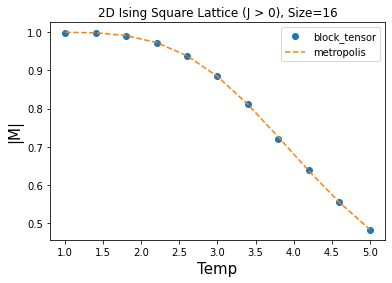

In [63]:
plt.plot(temp_array, m_abs_block_array, 'o', markersize=6, label='block_tensor')
plt.plot(temp_array, m_abs_metropolis_array, '--', label='metropolis')
plt.xlabel("Temp", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("2D Ising Square Lattice (J > 0), Size=16")
plt.legend()